<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/vae_prop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
x_train_bkg = x_train[np.where((y_train!=4)&(y_train!=5)&(y_train!=6))]

In [115]:
x_train_bkg.shape

(42819, 784)

In [0]:
from sklearn.model_selection import train_test_split
x_train_bkg,valid_x_train_bkg = train_test_split(x_train_bkg,
                                         test_size=0.2, 
                                         random_state=13)

In [0]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 32
epochs = 50

In [0]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [119]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           16416       dense_18[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 32)           16416       dense_18[0][0]                   
____________________________________________________________________________________________

In [120]:
encoder_z = Model(inputs,encoder(inputs)[2])
encoder_z.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  434752    
Total params: 434,752
Trainable params: 434,752
Non-trainable params: 0
_________________________________________________________________


In [0]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [122]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               402192    
Total params: 419,088
Trainable params: 419,088
Non-trainable params: 0
_________________________________________________________________


In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [125]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  434752    
_________________________________________________________________
decoder (Model)              (None, 784)               419088    
Total params: 853,840
Trainable params: 853,840
Non-trainable params: 0
_________________________________________________________________


In [126]:
vae_hist = vae.fit(x_train_bkg,
                   epochs=epochs,
                   batch_size=batch_size,
                   validation_data=(valid_x_train_bkg, None))

Train on 34255 samples, validate on 8564 samples
Epoch 1/50
34255/34255 [==============================] - 9s 271us/step - loss: 99.4711 - val_loss: 77.7269
Epoch 2/50
34255/34255 [==============================] - 8s 243us/step - loss: 72.8346 - val_loss: 69.4069
Epoch 3/50
34255/34255 [==============================] - 8s 240us/step - loss: 67.2153 - val_loss: 65.7725
Epoch 4/50
34255/34255 [==============================] - 8s 244us/step - loss: 64.4065 - val_loss: 63.6887
Epoch 5/50
34255/34255 [==============================] - 8s 239us/step - loss: 62.7188 - val_loss: 62.5786
Epoch 6/50
34255/34255 [==============================] - 8s 243us/step - loss: 61.6526 - val_loss: 61.2999
Epoch 7/50
34255/34255 [==============================] - 8s 243us/step - loss: 60.8542 - val_loss: 60.9211
Epoch 8/50
34255/34255 [==============================] - 8s 245us/step - loss: 60.2037 - val_loss: 60.1352
Epoch 9/50
34255/34255 [==============================] - 8s 245us/step - loss: 59.6981

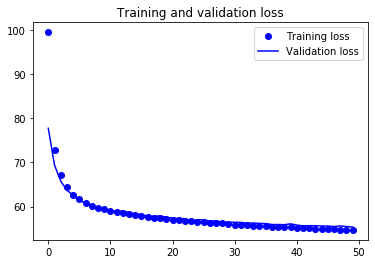

In [127]:
loss = vae_hist.history['loss']
val_loss = vae_hist.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
truth = np.zeros(len(y_test))

In [0]:
truth[np.where((y_test==4)|(y_test==5)|(y_test==6))]= 1

In [0]:
predict_nums=vae.predict(x_test)

In [131]:
predict_nums.shape

(10000, 784)

In [0]:
predict_loss_mse = np.mean(np.power(x_test - predict_nums, 2), axis =1)

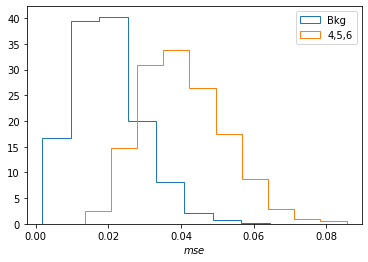

In [133]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg', density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6', density=True)
plt.legend(loc='best')
#plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$mse$')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.926776876749773


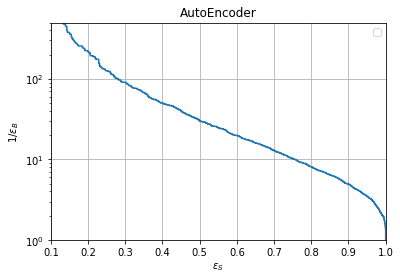

In [134]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(truth, predict_loss_mse)
print("roc_auc =", roc_auc_score(truth, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [96]:
encoder_z = 

In [0]:
# Dataset at the encoded layer
encoded_test = encoder_z.predict(x_test)
encoded_train_bkg = encoder_z.predict(x_train_bkg)

In [0]:
encoded_test = np.array(encoded_test)
encoded_train_bkg = np.array(encoded_train_bkg)

In [137]:
encoded_train_bkg.shape

(34255, 32)

In [0]:
hash_size = 20
sample_size, vec_size = encoded_train_bkg.shape
projections = np.random.randn(hash_size, vec_size)

In [0]:
hashed_encoded = list()

In [0]:
for i in range(sample_size):
  bools = ''
  for j in range(hash_size):
    bool = (np.dot(encoded_train_bkg[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
    #print(bools)
  hashed_encoded.append(bools)

In [141]:
len(hashed_encoded)

34255

In [0]:
def getDuplicatesWithInfo(hashed_encoded):
    ''' Get duplicate element in a list along with thier indices in list
     and frequency count'''
    dictOfElems = dict()
    index = 0
    # Iterate over each element in list and keep track of index
    for elem in hashed_encoded:
        # If element exists in dict then keep its index in lisr & increment its frequency
        if elem in dictOfElems:
            dictOfElems[elem][0] += 1
            dictOfElems[elem][1].append(index)
        else:
            # Add a new entry in dictionary 
            dictOfElems[elem] = [1, [index]]
        index += 1    
 
    dictOfElems = { key:value for key, value in dictOfElems.items() }
    return dictOfElems

In [0]:
dictOfElems = getDuplicatesWithInfo(hashed_encoded)
listHash = list()
for key, value in dictOfElems.items():
  listHash.append(key)

In [0]:

listHash = np.array(listHash)

In [0]:
tableSize= len(listHash)

In [0]:
sample_size, vec_size = encoded_test.shape

In [0]:

hash_truth = list()

In [148]:
count = 0
for i in range(sample_size):
  bools = ''
  a = 1
  for j in range(hash_size):
    bool = (np.dot(encoded_test[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
  #print(bools)
  for k in range(tableSize):
    #print("bools: ",bools)
    #print("listHash: ", listHash[k])
    if bools == listHash[k]:
      #print("listHash: ", listHash[k])
      a=0
      #print(a)
      break
  #count = 0
  if(a==1):
    count+=1
    #print(a)
  #print(count)
  hash_truth.append(a)
print(count)

8292


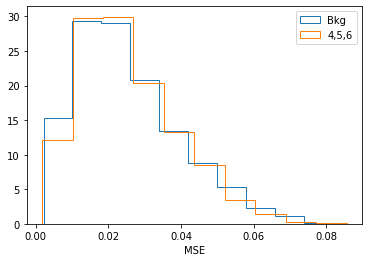

In [149]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if hash_truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg',density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6',density=True)
plt.legend(loc='best')
plt.xlabel('MSE')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
No handles with labels found to put in legend.


roc_auc = 0.5082529251410179


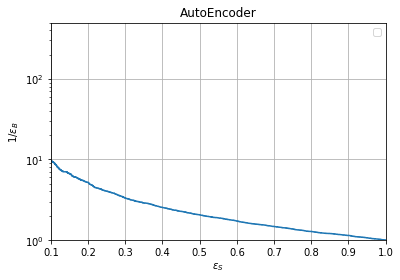

In [150]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(hash_truth, predict_loss_mse)
print("roc_auc =", roc_auc_score(hash_truth, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()